In [5]:
!pip install seaborn GPy

You should consider upgrading via the '/home/mirin/.pyenv/versions/3.9.5/envs/reproduction_frontiers_2021/bin/python3.9 -m pip install --upgrade pip' command.


In [6]:
cd ..

/mnt/f/frontiers_2021_reproduction


In [7]:
from motifboost.repertoire import repertoire_dataset_loader
from dataset import emerson_classification_cohort_split
import numba
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import GPy
import copy


In [8]:
repertoires = repertoire_dataset_loader("./data/preprocessed/","Emerson",
emerson_classification_cohort_split.filter_by_sample_id,emerson_classification_cohort_split.filter_by_repertoire)

RepertoireLoader_Multi: 100%|██████████| 760/760 [00:48<00:00, 15.61it/s]


In [9]:
len(repertoires)

760

In [10]:
from typing import List, Optional
import numpy as np
from motifboost.util import human_amino_acids, basic_void_mark
def trigram_features(
    seqs: List[str],
    alphabets: Optional[List[str]] = None,
    void_mark: Optional[str] = None,
    count_weights: Optional[List[int]] = None,
):  # int8 matrix value range: (0-20), shape :,32
    """
        Returns a feature vector, that each dimension represents a tri-mer.
        if count_weights is given, the feature is weighted by duplicate counts.
        If tfidf_weights is given, the features are converted by tfidf (a seq is seen as a doc)
    :param seqs:
    :param alphabets:
    :param void_mark:
    :param count_weights:
    :return:
    """
    if alphabets is None:
        alphabets = human_amino_acids
    if void_mark is None:
        void_mark = basic_void_mark
    if count_weights is None:
        count_weights = [1] * len(seqs)
    alphabets_with_void = [void_mark] + alphabets
    alphabet_size = len(alphabets_with_void)
    index2aa = dict(enumerate(alphabets_with_void))
    aa2index = {val: key for key, val in index2aa.items()}

    n = len(seqs)
    count_weights = np.array(count_weights,dtype=np.int64)
    seq_arrs = []
    for p in range(n):
        seq = [void_mark] + list(seqs[p]) + [void_mark]
        seq_arrs.append(np.array([aa2index[s] for s in seq]))
    return trigram(seq_arrs,alphabet_size,count_weights)

@numba.jit(nopython=True)
def trigram(seq_arrs:List[np.array],alphabet_size:int,count_weights:np.array):
    n = len(seq_arrs)
    arrays = np.zeros((n, alphabet_size ** 3), dtype=np.int64)
    for p in range(n):
        seq_arr = seq_arrs[p]
        for q in range(0, len(seq_arr) - 2):
            # no weight by counts
            arrays[
                p,
                seq_arr[q] * alphabet_size ** 2
                + seq_arr[q + 1] * alphabet_size ** 1
                + seq_arr[q + 2] * alphabet_size ** 0,
            ] += (
                1 * count_weights[p]
            )
    # np.ndarray.sum returns int
    reduced = arrays.sum(axis=0) # to cache
    return reduced


In [11]:
from joblib import Parallel, delayed
from tqdm import tqdm
from motifboost.repertoire import Repertoire

def trigram_features_wrapper(r):
    return trigram_features(r["seq"],human_amino_acids, basic_void_mark, r["cnt"]) 

# features =  Parallel(n_jobs=3)(delayed(trigram_features_wrapper)({"seq":r.sequences.get_all(),"cnt":r.counts}) for r in tqdm(repertoires))
features =  [trigram_features_wrapper({"seq":r.sequences.get_all(),"cnt":r.counts}) for r in tqdm(repertoires)]

100%|██████████| 760/760 [1:32:04<00:00,  7.27s/it]


In [12]:
cmv = [r.info["CMV"] for r in repertoires]

In [13]:
cmv[:10]

[False, False, True, False, False, False, True, False, False, False]

In [14]:
features = np.array(features)

In [15]:
features

array([[  0,   0,   0, ..., 267,   0, 309],
       [  0,   0,   0, ...,  34,  33,  62],
       [  0,   0,   0, ...,   0,  24, 126],
       ...,
       [  0,   0,   0, ...,   7,   4,  38],
       [  0,   0,   0, ...,  12,  22,  54],
       [  0,   0,   0, ...,  13,  12,  44]])

In [16]:
np.all(features >= 0) 

True

In [17]:
occurance_df = pd.DataFrame.from_dict({str(x):features[:,x] for x in range(features.shape[1])})
features2 = features / features.sum(axis=1).reshape(features.shape[0],1)
normalized_df = pd.DataFrame.from_dict({str(x):features2[:,x] for x in range(features2.shape[1])})

In [18]:
occurance_df["cmv"] = cmv
normalized_df["cmv"] = cmv

In [19]:
occurance_df["sample_id"] = [r.sample_id for r in repertoires]
normalized_df["sample_id"] = [r.sample_id for r in repertoires]

In [20]:
occurance_df["cohort"] = occurance_df["sample_id"].str[:3]
normalized_df["cohort"] = normalized_df["sample_id"].str[:3]

In [21]:
occurance_df

,0,1,2,3,4,5,6,7,8,9,...,9254,9255,9256,9257,9258,9259,9260,cmv,sample_id,cohort
0,0,0,0,0,0,0,0,0,0,0,...,152,829,286,427,267,0,309,False,HIP00110,HIP
1,0,0,0,0,0,0,0,0,0,0,...,129,238,303,202,34,33,62,False,HIP00169,HIP
2,0,0,0,0,0,0,0,0,0,0,...,126,216,256,443,0,24,126,True,HIP00594,HIP
3,0,0,0,0,0,0,0,0,0,0,...,909,848,1381,1345,52,6,487,False,HIP00602,HIP
4,0,0,0,0,0,0,0,0,0,0,...,87,291,256,158,0,3,84,False,HIP00614,HIP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,0,0,0,0,0,0,0,0,0,0,...,28,104,84,84,9,4,56,False,Keck0116,Kec
756,0,0,0,0,0,0,0,0,0,0,...,26,50,86,73,5,9,24,True,Keck0117,Kec
757,0,0,0,0,0,0,0,0,0,0,...,34,60,74,80,7,4,38,True,Keck0118,Kec
758,0,0,0,0,0,0,0,0,0,0,...,35,73,84,99,12,22,54,True,Keck0119,Kec


In [22]:
normalized_df

,0,1,2,3,4,5,6,7,8,9,...,9254,9255,9256,9257,9258,9259,9260,cmv,sample_id,cohort
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000003,0.000018,0.000006,0.000009,5.715483e-06,0.000000e+00,0.000007,False,HIP00110,HIP
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000008,0.000014,0.000018,0.000012,2.057574e-06,1.997058e-06,0.000004,False,HIP00169,HIP
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000004,0.000006,0.000007,0.000013,0.000000e+00,6.980441e-07,0.000004,True,HIP00594,HIP
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000008,0.000008,0.000013,0.000012,4.740137e-07,5.469389e-08,0.000004,False,HIP00602,HIP
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000004,0.000013,0.000011,0.000007,0.000000e+00,1.308060e-07,0.000004,False,HIP00614,HIP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000004,0.000015,0.000012,0.000012,1.262172e-06,5.609651e-07,0.000008,False,Keck0116,Kec
756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000004,0.000007,0.000012,0.000010,6.835579e-07,1.230404e-06,0.000003,True,Keck0117,Kec
757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000004,0.000006,0.000008,0.000008,7.375910e-07,4.214806e-07,0.000004,True,Keck0118,Kec
758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000005,0.000010,0.000012,0.000014,1.707563e-06,3.130532e-06,0.000008,True,Keck0119,Kec


In [23]:
# only use normalized_df / occurance_df after here

In [24]:
# GPLVM

In [25]:
X = np.array(normalized_df[[str(x) for x in range(9261)]])

In [26]:
(X >= 0).all()

True

In [27]:
input_dim = 2
X = np.array(normalized_df[[str(x) for x in range(9261)]])
kernel = GPy.kern.RBF(input_dim, ARD=True) + GPy.kern.Bias(input_dim) + GPy.kern.Linear(input_dim) + GPy.kern.White(input_dim)
model = GPy.models.BayesianGPLVM(X, input_dim, kernel=kernel, num_inducing=30)
model.optimize(messages=True, max_iters=5e3)

In [28]:
model.latent_space.parameters

[bayesian_gplvm.latent_space.mean:
 Param([[-0.0845324 ,  0.86873359],
        [ 0.50474582,  1.60551077],
        [-1.60751316,  0.97237488],
        ...,
        [-0.63248192, -2.17845002],
        [ 0.6351497 , -1.41993027],
        [ 0.87091601, -0.68516939]]),
 bayesian_gplvm.latent_space.variance:
 Param([[0.09246949, 0.03697896],
        [0.02501061, 0.03769602],
        [0.09531316, 0.08723825],
        ...,
        [0.07079927, 0.05864295],
        [0.07590716, 0.06682843],
        [0.05158065, 0.0569131 ]])]

In [29]:
means = model.latent_space.parameters[0]

In [30]:
visualize_df = pd.DataFrame.from_dict({"x": means[:,0],"y": means[:,1],"cmv":normalized_df["cmv"],"cohort":normalized_df["cohort"]})


In [31]:
plot_df = copy.deepcopy(visualize_df)
plot_df["CMV"] = ["Positive" if x else "Negative" for x in plot_df["cmv"] ]
del plot_df["cmv"]
plot_df["Cohort"] = ["Large" if x=="HIP" else "Small" for x in plot_df["cohort"] ]
del plot_df["cohort"]

In [32]:
def make_hue(cmv,cohort):
    if cmv and cohort=="HIP":
        return "Positive/Cohort 1"
    elif cmv:
        return "Positive/Cohort 2"
    elif cohort=="HIP":
        return "Negative/Cohort 1"
    else:
        return "Negative/Cohort 2"


plot_df["CMV/Cohort"] = [make_hue(x,y) for x,y in zip(visualize_df["cmv"],visualize_df["cohort"])] 

In [33]:
plot_df["Axis 1"] = plot_df["x"]
plot_df["Axis 2"] = plot_df["y"]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


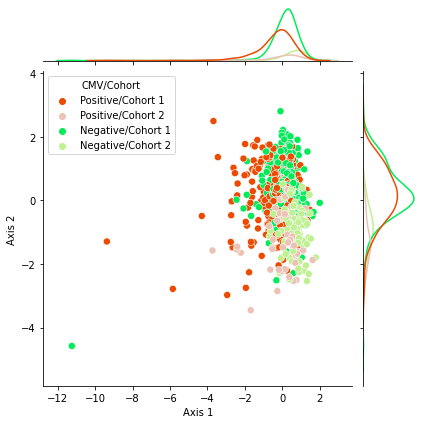

In [34]:
ax = sns.jointplot(data=plot_df,x="Axis 1",y="Axis 2",hue="CMV/Cohort",s=50,
hue_order=["Positive/Cohort 1","Positive/Cohort 2","Negative/Cohort 1","Negative/Cohort 2"],
palette={"Positive/Cohort 1":"#EB4A00","Positive/Cohort 2":"#EBC2B5","Negative/Cohort 1":"#00EB58","Negative/Cohort 2":"#BFF091"},marginal_kws={"fill":False})#,xlabel="Axis 1",ylabel="Axis 2")
# ax.legend(loc="upper left")
ax.fig.savefig("210830_unsupervised.eps")

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(~visualize_df["cmv"],np.array(means[:,0])),roc_auc_score(~visualize_df["cmv"],np.array(means[:,1]))

(0.6828571428571428, 0.5270378151260504)

In [36]:
roc_auc_score(visualize_df["cohort"]!="HIP",np.array(means[:,0])),roc_auc_score(visualize_df["cohort"]=="HIP",np.array(means[:,1]))

(0.703515625, 0.8738671875)

In [37]:
roc_auc_score(visualize_df["cohort"]=="HIP",np.array(means[:,0])),roc_auc_score(~(visualize_df["cohort"]=="HIP"),np.array(means[:,1]))

(0.29648437499999997, 0.12613281250000002)

In [38]:
# @coHORTWISE NO BUNBETUSNOU
roc_auc_score(~visualize_df[visualize_df["cohort"]=="HIP"]["cmv"],np.array(means[visualize_df["cohort"]=="HIP",0])),roc_auc_score(visualize_df[visualize_df["cohort"]=="HIP"]["cmv"],np.array(means[visualize_df["cohort"]=="HIP",1]))

(0.6834550813789568, 0.4734766707085047)

In [39]:
from scipy.stats import spearmanr
import numpy as np
spearmanr(visualize_df["cohort"]=="HIP",np.array(means[:,0])),spearmanr(~(visualize_df["cohort"]=="HIP"),np.array(means[:,1]))

(SpearmanrResult(correlation=-0.2570725909562866, pvalue=6.17204113947413e-13),
 SpearmanrResult(correlation=-0.47225369828073294, pvalue=1.77989510067216e-43))

In [40]:
spearmanr(~visualize_df["cmv"],np.array(means[:,0])),spearmanr(~visualize_df["cmv"],np.array(means[:,1]))

(SpearmanrResult(correlation=0.3149585773074823, pvalue=5.794565918272309e-19),
 SpearmanrResult(correlation=0.046570736327519506, pvalue=0.1996850972905822))

In [41]:
from sklearn.svm import SVC
clf = SVC(random_state=0)
cohort1_index = visualize_df["cohort"]=="HIP"
clf.fit(means[cohort1_index,:], visualize_df[cohort1_index]["cmv"])
clf.score(means[~cohort1_index,:], visualize_df[~cohort1_index]["cmv"])

0.65

In [67]:
from tqdm import tqdm
def project_vector_to_axis(slope,vector):
    s = np.array([1,slope])
    return np.dot(s,vector) / np.dot(s,s)

cohort1_index = visualize_df["cohort"]=="HIP"
cohort1_df = visualize_df[cohort1_index]
cohort1_means = np.array(means[cohort1_index,:])
cohort2_df = visualize_df[~cohort1_index]
cohort2_means = np.array(means[~cohort1_index,:])
cohort1_roc_auc = []
cohort2_roc_auc = []
cohort2_spearman = []
for i in tqdm(range(-1000,1000)):
    i = i/1000
    cohort1_projected_means = [project_vector_to_axis(i,x) for x in cohort1_means]
    cohort1_roc_auc.append(max(roc_auc_score(cohort1_df["cmv"],cohort1_projected_means),1-roc_auc_score(cohort1_df["cmv"],cohort1_projected_means)))
    cohort2_projected_means = [project_vector_to_axis(i,x) for x in cohort2_means]
    cohort2_roc_auc.append(max(roc_auc_score(cohort2_df["cmv"],cohort2_projected_means),1-roc_auc_score(cohort2_df["cmv"],cohort2_projected_means)))
    cohort2_spearman.append(spearmanr(cohort2_df["cmv"],cohort2_projected_means))


100%|██████████| 2000/2000 [00:15<00:00, 126.01it/s]


In [68]:
max_arg = np.array(cohort1_roc_auc).argmax()
print(max_arg)
print(cohort1_roc_auc[max_arg])
max_roc_auc = np.array(cohort2_roc_auc)[max_arg]
print(max_roc_auc)
print(cohort2_spearman[max_arg])

1251
0.6932540738769113
0.7479397556123899
SpearmanrResult(correlation=-0.42460026353598457, pvalue=1.3429136996267772e-06)


In [65]:
print(cohort1_roc_auc[max_arg-1])
print(cohort1_roc_auc[max_arg+1])

0.6932146413115271
0.6931357761807588


In [62]:
cohort1_roc_auc

[0.413687043444829,
 0.41359832017271464,
 0.41348002247656235,
 0.4134110154871401,
 0.4133420084977178,
 0.41325328522560356,
 0.4131152712467591,
 0.41305612239868295,
 0.4130265479746449,
 0.41295754098522264,
 0.41295754098522264,
 0.4128983921371465,
 0.41287867585445437,
 0.41285895957176233,
 0.41278995258234014,
 0.41274066187561,
 0.41265193860349575,
 0.4125336409073433,
 0.4124547757765751,
 0.4123561943631148,
 0.41229704551503854,
 0.4122280385256164,
 0.4121294571121561,
 0.4120505919813878,
 0.41200130127465767,
 0.4119421524265815,
 0.4118337128717751,
 0.41170555703427675,
 0.4116661244688926,
 0.41158725933812446,
 0.4115182523487022,
 0.41146896164197205,
 0.4113900965112038,
 0.41125208253235934,
 0.4112225081083213,
 0.41116335926024505,
 0.4110549197054388,
 0.41101548714005465,
 0.4109366220092864,
 0.4108577568785181,
 0.41077889174774984,
 0.4106901684756356,
 0.4106211614862134,
 0.41054229635544515,
 0.41050286379006107,
 0.4104634312246769,
 0.4103747079525

In [44]:
cohort2_roc_auc

[0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997442456,
 0.6342710997